# Calculating thresholds to identify heatwave events based on Ritwik Misra's code

## Import modules and define functions 

In [1]:
import dask as da
from dask.distributed import LocalCluster, Client
from datetime import date
import glob
import holoviews as hv
from matplotlib import pyplot as plt
import marineHeatWaves as mhw
import numpy as np
import time
import xarray as xr
%pylab inline
local_dir = "/g/data/e14/cp3790/dask-workers"
cluster = LocalCluster(processes=False, local_dir=local_dir)
client = Client(cluster)
client

Populating the interactive namespace from numpy and matplotlib


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/site-packages/distributed/worker.py:485: UserWarning: The local_dir keyword has moved to local_directory
  warnings.warn("The local_dir keyword has moved to local_directory")
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/contextlib.py:88: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Client Scheduler: inproc://10.0.64.2/27606/1 Dashboard: http://10.0.64.2/27606/1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [2]:
def reshape_data(da):
        da_groupby = list(da.groupby('time.dayofyear'))
        dayofyear = []
        da_dayofyear = []
        for item in list(da_groupby):
            dayofyear.append(item[0])
            da_tmp = item[1]
            da_tmp['time'] = da_tmp['time.year']
            da_tmp = da_tmp.rename({'time': 'year'})
            da_tmp = da_tmp.assign_coords(dayofyear=item[0])
            da_dayofyear.append(da_tmp)
        da_reshaped = xr.concat(da_dayofyear, dim='dayofyear')
        return da_reshaped

In [3]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

## Opening files

In [149]:
files = sorted(glob.glob('/g/data/e14/cp3790/Charuni/ERA5-new/era5_dailytmax_*.nc'))


era5_dailytmax_aus = xr.open_mfdataset(files, combine='by_coords').sel(time=slice('1979', '2018'), longitude=141.25, latitude=-33.75)
baseline_tmax = era5_dailytmax_aus["dmax"].load() #.sel(time=~((era5_dailytmax_aus["dmax"].time.dt.month == 2) & (era5_dailytmax_aus["dmax"].time.dt.day == 29)))
baseline_tmax.attrs['units'] = 'deg C'
obs_tmax = baseline_tmax.sel(time=slice('1983', '2012'))
obs_tmax.attrs['units'] = 'deg C'

## Reshaping and smoothening the data

In [156]:
# We get the data ready to have a rolling mean performed upon it. This is performed in the reshape_data function (created by Guillaume Serazin)

reshaped_tmax = reshape_data(baseline_tmax)

In [153]:
#The data is 'circularized', making rolling window processes possible for first and last days.

#tmax_reshaped = reshaped_tmax.isel(dayofyear = slice(0,-1)) # Removes day 366

In [157]:
start = reshaped_tmax[:31] # the first 31 days 
start['dayofyear'] = range(366,397) # the first 31 days will be 'stitched' to the last 31 days 
end = reshaped_tmax[-31:] # the last 31 days 
end['dayofyear'] = range(-30, 1) # the last 31 days will be 'stitched' to the first 31 days 
circular_tmax = xr.concat([end, reshaped_tmax, start], dim = 'dayofyear').chunk({'dayofyear' : 31})

## Calculating daily climatology with a 15 day rolling window, further smoothened by a 31-day window

In [158]:
raw_tmax = circular_tmax.mean('year')
tmax_climatology_smooth = raw_tmax.rolling(dayofyear = 15, center = True).mean() # smoothen it once with a 15-day rolling window
tmax_climatology_smoother = tmax_climatology_smooth.rolling(dayofyear = 31, center = True).mean() # smoothen it again by running a 31-day window 

In [159]:
tmax_climatology = tmax_climatology_smoother.isel(dayofyear = slice(31,-31)) # drop the first and last 31 days 
tmax_climatology.to_netcdf('/g/data/e14/cp3790/Charuni/climatology-single-gridpoint-366.nc')

## Calculating threshold (90th percentile of daily climatology)

In [160]:
percRolling = circular_tmax.rolling(dayofyear=15, center=True).construct('rolling_days')
# This takes in the circular_tmax, performs the percentile calculation, then creates a new dimension and coordinate names 
# to prepapre the data for the final output
stacked = percRolling.stack(z = ('rolling_days', 'year'))
rawPerc_data = da.array.apply_along_axis(np.nanpercentile, stacked.get_axis_num('z'), stacked.data, 90)
tmax_coords = circular_tmax.coords
new_coords = {name : tmax_coords[name] for name in tmax_coords if name != 'year'}
new_dims = [name for name in circular_tmax.dims if name != 'year']
rawPerc = xr.DataArray(rawPerc_data, coords = new_coords, dims = new_dims)

# Unlike in climatology (in which you get the rolling mean in a straightforward way, this uses np.nanpercentile,
# so we have to get a rolling construct first and then do the 90th percentile calculation)

In [161]:
#Final rolling mean over a month (smoothing)

tmax_threshold = rawPerc.rolling(dayofyear=31, center = True).mean()
print("Data smoothed, DONE.")
tmax_threshold = tmax_threshold.isel(dayofyear = slice(31,-31))
tmax_threshold.to_netcdf('/g/data/e14/cp3790/Charuni/thresh-single-gridpoint-366.nc')

Data smoothed, DONE.


## Identifying heatwave events

First, we identify days on which the daily tmax exceeds the corresponding thrshold, which are then filtered.

From these, the consecutive events are identified and then the events with a minimum duration of three days are selected.

In [162]:
heatwave_days = (obs_tmax.groupby('time.dayofyear') > tmax_threshold).astype(int)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 30 times more chunks
  return self.array[key]


In [163]:
# Creating new coordinate for event duration 

heatwave_days = heatwave_days.assign_coords({'event_duration': heatwave_days.dayofyear*0})

In [164]:
heatwave_events = np.where(heatwave_days==1)

In [165]:
counters = consecutive(heatwave_events[0].tolist())

In [166]:
hottest_single = [(x[0], x.size) for x in counters if x.size >= 3]

The duration of the event is assigned to the event_duration coordinates

In [167]:
for x in counters:
    if x.size >= 3:
        for y in range(x.size):
            heatwave_days.event_duration[x[0] +y -1] = x.size

## Plotting

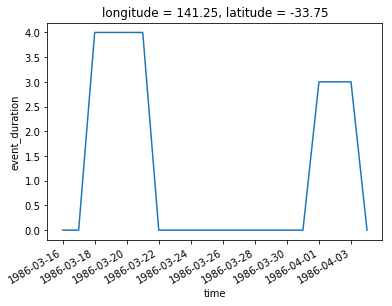

In [168]:
heatwave_days.event_duration[1170:1190].plot()